In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
import helper
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report,accuracy_score
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

balanced_path_data = 'drive/MyDrive/balanced_csic_data_64/training'
#imbalanced_path_data = 'drive/MyDrive/imbalanced_csic_data_64/training'

feature_extract = True

In [4]:
mean = torch.tensor([135.31470632, 124.53849418, 103.39646082])
std = torch.tensor([5.18153318, 4.14170719, 5.17011963])

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [5]:
def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

# load the balanced dataset
balanced_dataset = datasets.ImageFolder(balanced_path_data, transform=transform)
balanced_datasets = train_val_dataset(balanced_dataset)

# #load the imbalanced dataset
# imbalanced_dataset = datasets.ImageFolder(imbalanced_path_data, transform=transform)
# imbalanced_datasets = train_val_dataset(imbalanced_dataset)

class_dict = balanced_dataset.class_to_idx


In [6]:
batch_size = 32
balanced_dataloaders_dict = {x: torch.utils.data.DataLoader(balanced_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
#imbalanced_dataloaders_dict = {x: torch.utils.data.DataLoader(imbalanced_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}


In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [8]:
# balanced_data_iter = iter(balanced_dataloaders_dict['train'])
# images, labels = next(balanced_data_iter)

# imbalanced_data_iter = iter(imbalanced_dataloaders_dict['train'])
# images, labels = next(imbalanced_data_iter)

In [9]:
from tqdm import trange
from tqdm import tqdm

In [10]:
# def getCategoricalAccuracy(pred, true, class_names:dict):
#   for cl in class_names.keys():
#     class_id = int(class_names[cl])
#     locs = np.where(np.array(true)==class_id)
#     class_acc = sum(pred[locs] == int(class_id))/len(locs)
#     print('Accuracy for {}:{}'.format(str(cl), class_acc))

def train_model(model, dataloaders, criterion, optimizer, num_epochs=20, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloaders[phase],unit = 'batch') as tepoch:
              # Iterate over data.
              for inputs, labels in tepoch:
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      # Get model outputs and calculate loss
                      # Special case for inception because in training it has an auxiliary output. In train
                      #   mode we calculate the loss by summing the final output and the auxiliary output
                      #   but in testing we only consider the final output.
                      if is_inception and phase == 'train':
                          # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                          outputs, aux_outputs = model(inputs)
                          loss1 = criterion(outputs, labels)
                          loss2 = criterion(aux_outputs, labels)
                          loss = loss1 + 0.4*loss2
                      else:
                          outputs = model(inputs)
                          loss = criterion(outputs, labels)

                      _, preds = torch.max(outputs, 1)
                      

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  #getCategoricalAccuracy(preds, labels.data, class_dict)
                  running_corrects += torch.sum(preds == labels.data)

              epoch_loss = running_loss / len(dataloaders[phase].dataset)
              epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

              print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              # deep copy the model
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
              if phase == 'val':
                  val_acc_history.append(epoch_acc)
              if phase == 'train':
                  train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [11]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
# ResNet 18
model_ft_balanced = models.resnet18(pretrained=False)
set_parameter_requires_grad(model_ft_balanced, True)
model_ft_balanced.fc = nn.Linear(512, len(balanced_dataset.class_to_idx))
input_size = 224
model_ft_balanced = model_ft_balanced.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_balanced.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_balanced.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_balanced.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)

# Setup the loss fxn
import time
import copy
criterion = nn.CrossEntropyLoss()
epoch = 50

# Training a pretrained Resnet18 on a balanced dataset
model_ft_balanced, balanced_val_hist, balanced_tr_hist  = train_model(model_ft_balanced, balanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/49
----------


100%|██████████| 94/94 [00:09<00:00,  9.99batch/s]


train Loss: 1.3313 Acc: 0.4411


100%|██████████| 11/11 [00:01<00:00,  9.83batch/s]


val Loss: 1.1527 Acc: 0.5120

Epoch 1/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.10batch/s]


train Loss: 1.1202 Acc: 0.4662


100%|██████████| 11/11 [00:01<00:00, 10.17batch/s]


val Loss: 1.0769 Acc: 0.5120

Epoch 2/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.02batch/s]


train Loss: 1.1163 Acc: 0.4458


100%|██████████| 11/11 [00:01<00:00, 10.45batch/s]


val Loss: 1.0456 Acc: 0.5120

Epoch 3/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.98batch/s]


train Loss: 1.1777 Acc: 0.4642


100%|██████████| 11/11 [00:01<00:00, 10.42batch/s]


val Loss: 1.0077 Acc: 0.3735

Epoch 4/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.06batch/s]


train Loss: 1.0678 Acc: 0.4742


100%|██████████| 11/11 [00:01<00:00, 10.39batch/s]


val Loss: 1.0784 Acc: 0.5120

Epoch 5/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.08batch/s]


train Loss: 1.2205 Acc: 0.4722


100%|██████████| 11/11 [00:01<00:00, 10.36batch/s]


val Loss: 1.0200 Acc: 0.5120

Epoch 6/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.05batch/s]


train Loss: 1.0766 Acc: 0.4839


100%|██████████| 11/11 [00:01<00:00, 10.11batch/s]


val Loss: 1.1950 Acc: 0.2801

Epoch 7/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.97batch/s]


train Loss: 1.0694 Acc: 0.4779


100%|██████████| 11/11 [00:01<00:00, 10.25batch/s]


val Loss: 1.1389 Acc: 0.5120

Epoch 8/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.97batch/s]


train Loss: 1.1513 Acc: 0.4779


100%|██████████| 11/11 [00:01<00:00, 10.21batch/s]


val Loss: 1.0620 Acc: 0.5120

Epoch 9/49
----------


100%|██████████| 94/94 [00:10<00:00,  9.11batch/s]


train Loss: 1.1049 Acc: 0.4809


100%|██████████| 11/11 [00:01<00:00,  9.93batch/s]


val Loss: 1.0162 Acc: 0.5090

Epoch 10/49
----------


100%|██████████| 94/94 [00:09<00:00,  9.46batch/s]


train Loss: 1.0861 Acc: 0.4726


100%|██████████| 11/11 [00:01<00:00, 10.29batch/s]


val Loss: 1.1278 Acc: 0.5120

Epoch 11/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.00batch/s]


train Loss: 1.1405 Acc: 0.4813


100%|██████████| 11/11 [00:01<00:00, 10.24batch/s]


val Loss: 1.0402 Acc: 0.4849

Epoch 12/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.92batch/s]


train Loss: 1.0904 Acc: 0.4726


100%|██████████| 11/11 [00:01<00:00, 10.11batch/s]


val Loss: 0.9685 Acc: 0.5120

Epoch 13/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.93batch/s]


train Loss: 1.0933 Acc: 0.4829


100%|██████████| 11/11 [00:01<00:00, 10.10batch/s]


val Loss: 1.0053 Acc: 0.5120

Epoch 14/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.99batch/s]


train Loss: 1.2381 Acc: 0.4782


100%|██████████| 11/11 [00:01<00:00, 10.36batch/s]


val Loss: 1.5254 Acc: 0.4367

Epoch 15/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.97batch/s]


train Loss: 1.1908 Acc: 0.4779


100%|██████████| 11/11 [00:01<00:00, 10.16batch/s]


val Loss: 1.0006 Acc: 0.5120

Epoch 16/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.89batch/s]


train Loss: 1.0710 Acc: 0.5087


100%|██████████| 11/11 [00:01<00:00, 10.13batch/s]


val Loss: 1.2814 Acc: 0.5120

Epoch 17/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.02batch/s]


train Loss: 1.0404 Acc: 0.4950


100%|██████████| 11/11 [00:01<00:00, 10.24batch/s]


val Loss: 0.9513 Acc: 0.5120

Epoch 18/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.02batch/s]


train Loss: 1.1473 Acc: 0.4890


100%|██████████| 11/11 [00:01<00:00, 10.26batch/s]


val Loss: 0.9543 Acc: 0.5392

Epoch 19/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.03batch/s]


train Loss: 1.0289 Acc: 0.5157


100%|██████████| 11/11 [00:01<00:00, 10.29batch/s]


val Loss: 1.1176 Acc: 0.5120

Epoch 20/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.89batch/s]


train Loss: 1.0811 Acc: 0.4883


100%|██████████| 11/11 [00:01<00:00,  8.23batch/s]


val Loss: 1.3453 Acc: 0.2741

Epoch 21/49
----------


100%|██████████| 94/94 [00:09<00:00,  9.47batch/s]


train Loss: 1.0574 Acc: 0.5127


100%|██████████| 11/11 [00:01<00:00, 10.16batch/s]


val Loss: 1.1404 Acc: 0.4488

Epoch 22/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.00batch/s]


train Loss: 1.0546 Acc: 0.5047


100%|██████████| 11/11 [00:01<00:00, 10.00batch/s]


val Loss: 0.9545 Acc: 0.5843

Epoch 23/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.92batch/s]


train Loss: 1.1009 Acc: 0.5057


100%|██████████| 11/11 [00:01<00:00, 10.18batch/s]


val Loss: 0.9512 Acc: 0.5120

Epoch 24/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.88batch/s]


train Loss: 1.0612 Acc: 0.5044


100%|██████████| 11/11 [00:01<00:00, 10.01batch/s]


val Loss: 1.1945 Acc: 0.4428

Epoch 25/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.96batch/s]


train Loss: 1.1207 Acc: 0.4967


100%|██████████| 11/11 [00:01<00:00, 10.11batch/s]


val Loss: 1.2520 Acc: 0.4367

Epoch 26/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.99batch/s]


train Loss: 1.1389 Acc: 0.5050


100%|██████████| 11/11 [00:01<00:00, 10.24batch/s]


val Loss: 0.9776 Acc: 0.6777

Epoch 27/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.99batch/s]


train Loss: 1.1152 Acc: 0.5090


100%|██████████| 11/11 [00:01<00:00, 10.28batch/s]


val Loss: 0.9790 Acc: 0.4970

Epoch 28/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.88batch/s]


train Loss: 1.0382 Acc: 0.5137


100%|██████████| 11/11 [00:01<00:00, 10.17batch/s]


val Loss: 1.0812 Acc: 0.4639

Epoch 29/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.05batch/s]


train Loss: 1.0495 Acc: 0.5261


100%|██████████| 11/11 [00:01<00:00, 10.16batch/s]


val Loss: 0.9941 Acc: 0.4789

Epoch 30/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.02batch/s]


train Loss: 1.0344 Acc: 0.5295


100%|██████████| 11/11 [00:01<00:00, 10.07batch/s]


val Loss: 1.3183 Acc: 0.3524

Epoch 31/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.56batch/s]


train Loss: 1.0931 Acc: 0.5047


100%|██████████| 11/11 [00:01<00:00, 10.15batch/s]


val Loss: 0.9662 Acc: 0.5934

Epoch 32/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.94batch/s]


train Loss: 1.0140 Acc: 0.5204


100%|██████████| 11/11 [00:01<00:00,  9.92batch/s]


val Loss: 1.2280 Acc: 0.4398

Epoch 33/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.95batch/s]


train Loss: 1.0195 Acc: 0.5348


100%|██████████| 11/11 [00:01<00:00,  9.92batch/s]


val Loss: 0.9068 Acc: 0.6777

Epoch 34/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.09batch/s]


train Loss: 1.0428 Acc: 0.5288


100%|██████████| 11/11 [00:01<00:00, 10.14batch/s]


val Loss: 1.1310 Acc: 0.5120

Epoch 35/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.98batch/s]


train Loss: 1.0110 Acc: 0.5318


100%|██████████| 11/11 [00:01<00:00, 10.23batch/s]


val Loss: 1.1113 Acc: 0.5120

Epoch 36/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.03batch/s]


train Loss: 1.0201 Acc: 0.5288


100%|██████████| 11/11 [00:01<00:00, 10.09batch/s]


val Loss: 0.9465 Acc: 0.6687

Epoch 37/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.96batch/s]


train Loss: 1.0080 Acc: 0.5448


100%|██████████| 11/11 [00:01<00:00, 10.33batch/s]


val Loss: 0.9876 Acc: 0.5120

Epoch 38/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.65batch/s]


train Loss: 1.0563 Acc: 0.5295


100%|██████████| 11/11 [00:01<00:00, 10.21batch/s]


val Loss: 1.0073 Acc: 0.5120

Epoch 39/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.98batch/s]


train Loss: 1.0869 Acc: 0.5134


100%|██████████| 11/11 [00:01<00:00, 10.15batch/s]


val Loss: 1.4629 Acc: 0.4127

Epoch 40/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.91batch/s]


train Loss: 1.0680 Acc: 0.5144


100%|██████████| 11/11 [00:01<00:00, 10.14batch/s]


val Loss: 1.0103 Acc: 0.6717

Epoch 41/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.79batch/s]


train Loss: 1.1010 Acc: 0.5218


100%|██████████| 11/11 [00:01<00:00, 10.15batch/s]


val Loss: 0.9977 Acc: 0.5241

Epoch 42/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.81batch/s]


train Loss: 1.0101 Acc: 0.5361


100%|██████████| 11/11 [00:01<00:00, 10.06batch/s]


val Loss: 1.1883 Acc: 0.5120

Epoch 43/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.88batch/s]


train Loss: 0.9940 Acc: 0.5428


100%|██████████| 11/11 [00:01<00:00, 10.26batch/s]


val Loss: 0.9302 Acc: 0.6355

Epoch 44/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.93batch/s]


train Loss: 1.0265 Acc: 0.5469


100%|██████████| 11/11 [00:01<00:00,  9.96batch/s]


val Loss: 1.2386 Acc: 0.4518

Epoch 45/49
----------


100%|██████████| 94/94 [00:08<00:00, 11.11batch/s]


train Loss: 1.0076 Acc: 0.5432


100%|██████████| 11/11 [00:01<00:00, 10.08batch/s]


val Loss: 1.3392 Acc: 0.4608

Epoch 46/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.98batch/s]


train Loss: 1.0837 Acc: 0.5141


100%|██████████| 11/11 [00:01<00:00, 10.26batch/s]


val Loss: 1.0025 Acc: 0.5120

Epoch 47/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.99batch/s]


train Loss: 1.0216 Acc: 0.5335


100%|██████████| 11/11 [00:01<00:00, 10.22batch/s]


val Loss: 1.0749 Acc: 0.5120

Epoch 48/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.96batch/s]


train Loss: 1.3325 Acc: 0.4819


100%|██████████| 11/11 [00:01<00:00, 10.11batch/s]


val Loss: 1.1938 Acc: 0.4639

Epoch 49/49
----------


100%|██████████| 94/94 [00:08<00:00, 10.85batch/s]


train Loss: 1.0964 Acc: 0.5284


100%|██████████| 11/11 [00:01<00:00, 10.26batch/s]

val Loss: 1.0628 Acc: 0.4669

Training complete in 8m 10s
Best val Acc: 0.677711


In [15]:
#ResNet 50
model_ft_balanced2 = models.resnet50(pretrained=False)
set_parameter_requires_grad(model_ft_balanced2, True)
model_ft_balanced2.fc = nn.Linear(2048, len(balanced_dataset.class_to_idx))
input_size = 224
model_ft_balanced2 = model_ft_balanced2.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_balanced2.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_balanced2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_balanced2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)

# Training a pretrained Resnet50 on a balanced dataset
model_ft_balanced2, balanced_val_hist2, balanced_tr_hist2  = train_model(model_ft_balanced2, balanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.12batch/s]


train Loss: 4.1614 Acc: 0.4374


100%|██████████| 11/11 [00:01<00:00,  9.27batch/s]


val Loss: 2.3096 Acc: 0.4518

Epoch 1/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.17batch/s]


train Loss: 1.7866 Acc: 0.5114


100%|██████████| 11/11 [00:01<00:00,  9.35batch/s]


val Loss: 1.7007 Acc: 0.3946

Epoch 2/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.14batch/s]


train Loss: 1.2651 Acc: 0.5629


100%|██████████| 11/11 [00:01<00:00,  9.37batch/s]


val Loss: 2.3094 Acc: 0.5271

Epoch 3/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.08batch/s]


train Loss: 1.8483 Acc: 0.5402


100%|██████████| 11/11 [00:01<00:00,  9.39batch/s]


val Loss: 1.4375 Acc: 0.6506

Epoch 4/49
----------


100%|██████████| 94/94 [00:10<00:00,  8.97batch/s]


train Loss: 1.7676 Acc: 0.5954


100%|██████████| 11/11 [00:01<00:00,  9.22batch/s]


val Loss: 1.3594 Acc: 0.5693

Epoch 5/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.07batch/s]


train Loss: 1.9120 Acc: 0.5338


100%|██████████| 11/11 [00:01<00:00,  9.15batch/s]


val Loss: 5.2844 Acc: 0.1928

Epoch 6/49
----------


100%|██████████| 94/94 [00:09<00:00,  9.98batch/s]


train Loss: 1.6611 Acc: 0.6004


100%|██████████| 11/11 [00:01<00:00,  9.15batch/s]


val Loss: 0.8869 Acc: 0.6777

Epoch 7/49
----------


100%|██████████| 94/94 [00:09<00:00,  9.99batch/s]


train Loss: 1.2624 Acc: 0.6258


100%|██████████| 11/11 [00:01<00:00,  9.37batch/s]


val Loss: 4.0131 Acc: 0.3765

Epoch 8/49
----------


100%|██████████| 94/94 [00:09<00:00,  9.92batch/s]


train Loss: 2.3929 Acc: 0.5663


100%|██████████| 11/11 [00:01<00:00,  9.37batch/s]


val Loss: 1.3684 Acc: 0.5663

Epoch 9/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.09batch/s]


train Loss: 1.3202 Acc: 0.6017


100%|██████████| 11/11 [00:01<00:00,  9.14batch/s]


val Loss: 0.9878 Acc: 0.7259

Epoch 10/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.08batch/s]


train Loss: 1.3366 Acc: 0.6288


100%|██████████| 11/11 [00:01<00:00,  8.95batch/s]


val Loss: 2.3552 Acc: 0.4428

Epoch 11/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.08batch/s]


train Loss: 1.7267 Acc: 0.5790


100%|██████████| 11/11 [00:01<00:00,  9.04batch/s]


val Loss: 1.3119 Acc: 0.6928

Epoch 12/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.12batch/s]


train Loss: 1.4324 Acc: 0.6442


100%|██████████| 11/11 [00:01<00:00,  9.16batch/s]


val Loss: 3.2712 Acc: 0.1807

Epoch 13/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.17batch/s]


train Loss: 1.6257 Acc: 0.6198


100%|██████████| 11/11 [00:01<00:00,  9.09batch/s]


val Loss: 2.0934 Acc: 0.5693

Epoch 14/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.06batch/s]


train Loss: 1.4774 Acc: 0.6148


100%|██████████| 11/11 [00:01<00:00,  8.96batch/s]


val Loss: 1.0649 Acc: 0.6054

Epoch 15/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.16batch/s]


train Loss: 1.4643 Acc: 0.6493


100%|██████████| 11/11 [00:01<00:00,  9.25batch/s]


val Loss: 0.9685 Acc: 0.7048

Epoch 16/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.08batch/s]


train Loss: 1.3988 Acc: 0.6252


100%|██████████| 11/11 [00:01<00:00,  9.43batch/s]


val Loss: 1.0840 Acc: 0.6657

Epoch 17/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.13batch/s]


train Loss: 1.2442 Acc: 0.6476


100%|██████████| 11/11 [00:01<00:00,  9.18batch/s]


val Loss: 1.3994 Acc: 0.7380

Epoch 18/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.14batch/s]


train Loss: 1.1055 Acc: 0.6583


100%|██████████| 11/11 [00:01<00:00,  9.13batch/s]


val Loss: 0.9155 Acc: 0.7229

Epoch 19/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.15batch/s]


train Loss: 1.2184 Acc: 0.6506


100%|██████████| 11/11 [00:01<00:00,  9.02batch/s]


val Loss: 0.9735 Acc: 0.5572

Epoch 20/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.09batch/s]


train Loss: 1.9537 Acc: 0.6593


100%|██████████| 11/11 [00:01<00:00,  8.96batch/s]


val Loss: 1.3287 Acc: 0.7289

Epoch 21/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.21batch/s]


train Loss: 1.1144 Acc: 0.6834


100%|██████████| 11/11 [00:01<00:00,  9.15batch/s]


val Loss: 0.7383 Acc: 0.7289

Epoch 22/49
----------


100%|██████████| 94/94 [00:09<00:00,  9.97batch/s]


train Loss: 1.2908 Acc: 0.6386


100%|██████████| 11/11 [00:01<00:00,  9.21batch/s]


val Loss: 0.8256 Acc: 0.7410

Epoch 23/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.10batch/s]


train Loss: 1.3351 Acc: 0.6406


100%|██████████| 11/11 [00:01<00:00,  9.35batch/s]


val Loss: 1.5122 Acc: 0.5753

Epoch 24/49
----------


100%|██████████| 94/94 [00:09<00:00,  9.96batch/s]


train Loss: 1.4157 Acc: 0.6058


100%|██████████| 11/11 [00:01<00:00,  9.02batch/s]


val Loss: 1.2648 Acc: 0.5693

Epoch 25/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.11batch/s]


train Loss: 1.3053 Acc: 0.6382


100%|██████████| 11/11 [00:01<00:00,  9.28batch/s]


val Loss: 1.5199 Acc: 0.5572

Epoch 26/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.13batch/s]


train Loss: 1.1363 Acc: 0.6466


100%|██████████| 11/11 [00:01<00:00,  9.08batch/s]


val Loss: 2.0022 Acc: 0.4639

Epoch 27/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.04batch/s]


train Loss: 1.3891 Acc: 0.6121


100%|██████████| 11/11 [00:01<00:00,  9.21batch/s]


val Loss: 1.2096 Acc: 0.7289

Epoch 28/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.03batch/s]


train Loss: 1.7271 Acc: 0.6516


100%|██████████| 11/11 [00:01<00:00,  9.06batch/s]


val Loss: 2.1960 Acc: 0.6536

Epoch 29/49
----------


100%|██████████| 94/94 [00:09<00:00,  9.96batch/s]


train Loss: 1.2354 Acc: 0.6660


100%|██████████| 11/11 [00:01<00:00,  8.94batch/s]


val Loss: 2.1776 Acc: 0.4729

Epoch 30/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.02batch/s]


train Loss: 2.0971 Acc: 0.5857


100%|██████████| 11/11 [00:01<00:00,  9.20batch/s]


val Loss: 2.3557 Acc: 0.4699

Epoch 31/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.12batch/s]


train Loss: 1.2204 Acc: 0.6730


100%|██████████| 11/11 [00:01<00:00,  9.20batch/s]


val Loss: 1.4838 Acc: 0.7319

Epoch 32/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.08batch/s]


train Loss: 1.0945 Acc: 0.6908


100%|██████████| 11/11 [00:01<00:00,  9.15batch/s]


val Loss: 0.6336 Acc: 0.7590

Epoch 33/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.12batch/s]


train Loss: 0.9771 Acc: 0.6948


100%|██████████| 11/11 [00:01<00:00,  8.98batch/s]


val Loss: 0.7712 Acc: 0.7651

Epoch 34/49
----------


100%|██████████| 94/94 [00:10<00:00,  8.91batch/s]


train Loss: 1.1545 Acc: 0.6740


100%|██████████| 11/11 [00:01<00:00,  9.22batch/s]


val Loss: 1.4181 Acc: 0.6777

Epoch 35/49
----------


100%|██████████| 94/94 [00:09<00:00,  9.92batch/s]


train Loss: 1.4333 Acc: 0.6419


100%|██████████| 11/11 [00:01<00:00,  9.04batch/s]


val Loss: 2.2665 Acc: 0.5512

Epoch 36/49
----------


100%|██████████| 94/94 [00:09<00:00,  9.96batch/s]


train Loss: 1.1571 Acc: 0.6750


100%|██████████| 11/11 [00:01<00:00,  9.16batch/s]


val Loss: 2.9286 Acc: 0.4759

Epoch 37/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.00batch/s]


train Loss: 1.4170 Acc: 0.6724


100%|██████████| 11/11 [00:01<00:00,  9.19batch/s]


val Loss: 1.1029 Acc: 0.7018

Epoch 38/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.15batch/s]


train Loss: 1.0869 Acc: 0.6790


100%|██████████| 11/11 [00:01<00:00,  9.16batch/s]


val Loss: 0.8143 Acc: 0.7259

Epoch 39/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.07batch/s]


train Loss: 1.8633 Acc: 0.6563


100%|██████████| 11/11 [00:01<00:00,  9.09batch/s]


val Loss: 2.8798 Acc: 0.4608

Epoch 40/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.12batch/s]


train Loss: 1.4962 Acc: 0.6657


100%|██████████| 11/11 [00:01<00:00,  9.30batch/s]


val Loss: 0.8352 Acc: 0.7530

Epoch 41/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.03batch/s]


train Loss: 2.0542 Acc: 0.6145


100%|██████████| 11/11 [00:01<00:00,  9.19batch/s]


val Loss: 3.8728 Acc: 0.5452

Epoch 42/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.11batch/s]


train Loss: 1.9961 Acc: 0.6342


100%|██████████| 11/11 [00:01<00:00,  8.97batch/s]


val Loss: 2.3739 Acc: 0.5000

Epoch 43/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.09batch/s]


train Loss: 1.1643 Acc: 0.6981


100%|██████████| 11/11 [00:01<00:00,  8.95batch/s]


val Loss: 1.9235 Acc: 0.6145

Epoch 44/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.07batch/s]


train Loss: 1.7532 Acc: 0.6124


100%|██████████| 11/11 [00:01<00:00,  9.10batch/s]


val Loss: 0.7650 Acc: 0.7560

Epoch 45/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.00batch/s]


train Loss: 1.4398 Acc: 0.6841


100%|██████████| 11/11 [00:01<00:00,  9.05batch/s]


val Loss: 1.8628 Acc: 0.5241

Epoch 46/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.14batch/s]


train Loss: 1.3145 Acc: 0.6864


100%|██████████| 11/11 [00:01<00:00,  9.06batch/s]


val Loss: 1.7770 Acc: 0.5843

Epoch 47/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.08batch/s]


train Loss: 1.0592 Acc: 0.6948


100%|██████████| 11/11 [00:01<00:00,  9.09batch/s]


val Loss: 1.1611 Acc: 0.7319

Epoch 48/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.14batch/s]


train Loss: 1.7402 Acc: 0.6325


100%|██████████| 11/11 [00:01<00:00,  9.07batch/s]


val Loss: 0.9083 Acc: 0.6988

Epoch 49/49
----------


100%|██████████| 94/94 [00:09<00:00, 10.03batch/s]


train Loss: 1.5508 Acc: 0.6533


100%|██████████| 11/11 [00:01<00:00,  9.25batch/s]

val Loss: 0.9917 Acc: 0.7500

Training complete in 8m 51s
Best val Acc: 0.765060


In [16]:
#ResNet 152
model_ft_balanced3 = models.resnet152(pretrained=False)
set_parameter_requires_grad(model_ft_balanced3, True)
model_ft_balanced3.fc = nn.Linear(2048, len(balanced_dataset.class_to_idx))
input_size = 224
model_ft_balanced3 = model_ft_balanced3.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_balanced3.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_balanced3.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_balanced3.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)

# Training a pretrained Resnet50 on a balanced dataset
model_ft_balanced3, balanced_val_hist3, balanced_tr_hist3  = train_model(model_ft_balanced3, balanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.32batch/s]


train Loss: 3.1951 Acc: 0.4123


100%|██████████| 11/11 [00:01<00:00,  6.71batch/s]


val Loss: 2.7395 Acc: 0.3614

Epoch 1/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.35batch/s]


train Loss: 1.5040 Acc: 0.4572


100%|██████████| 11/11 [00:01<00:00,  6.64batch/s]


val Loss: 1.1494 Acc: 0.5030

Epoch 2/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.38batch/s]


train Loss: 2.5706 Acc: 0.4709


100%|██████████| 11/11 [00:01<00:00,  6.59batch/s]


val Loss: 2.6941 Acc: 0.4699

Epoch 3/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.35batch/s]


train Loss: 3.0021 Acc: 0.4451


100%|██████████| 11/11 [00:01<00:00,  6.80batch/s]


val Loss: 2.4896 Acc: 0.3886

Epoch 4/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.31batch/s]


train Loss: 1.7635 Acc: 0.4756


100%|██████████| 11/11 [00:01<00:00,  6.73batch/s]


val Loss: 1.2963 Acc: 0.6657

Epoch 5/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.30batch/s]


train Loss: 1.6570 Acc: 0.4906


100%|██████████| 11/11 [00:01<00:00,  6.67batch/s]


val Loss: 1.4660 Acc: 0.4639

Epoch 6/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.34batch/s]


train Loss: 1.9237 Acc: 0.4873


100%|██████████| 11/11 [00:01<00:00,  6.63batch/s]


val Loss: 4.8779 Acc: 0.4006

Epoch 7/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.33batch/s]


train Loss: 2.3371 Acc: 0.4890


100%|██████████| 11/11 [00:01<00:00,  6.69batch/s]


val Loss: 1.8156 Acc: 0.5904

Epoch 8/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.32batch/s]


train Loss: 1.6819 Acc: 0.5084


100%|██████████| 11/11 [00:01<00:00,  6.74batch/s]


val Loss: 1.7449 Acc: 0.5000

Epoch 9/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.33batch/s]


train Loss: 2.0911 Acc: 0.5201


100%|██████████| 11/11 [00:01<00:00,  6.60batch/s]


val Loss: 3.6979 Acc: 0.3614

Epoch 10/49
----------


100%|██████████| 94/94 [00:13<00:00,  6.97batch/s]


train Loss: 2.0541 Acc: 0.5191


100%|██████████| 11/11 [00:01<00:00,  6.46batch/s]


val Loss: 1.2708 Acc: 0.6566

Epoch 11/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.32batch/s]


train Loss: 3.0843 Acc: 0.4578


100%|██████████| 11/11 [00:01<00:00,  6.62batch/s]


val Loss: 2.9107 Acc: 0.5753

Epoch 12/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.33batch/s]


train Loss: 2.0125 Acc: 0.5308


100%|██████████| 11/11 [00:01<00:00,  6.60batch/s]


val Loss: 1.1171 Acc: 0.5422

Epoch 13/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.31batch/s]


train Loss: 1.3899 Acc: 0.5335


100%|██████████| 11/11 [00:01<00:00,  6.68batch/s]


val Loss: 3.8046 Acc: 0.3675

Epoch 14/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.34batch/s]


train Loss: 1.5404 Acc: 0.5345


100%|██████████| 11/11 [00:01<00:00,  6.60batch/s]


val Loss: 1.6093 Acc: 0.5331

Epoch 15/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.32batch/s]


train Loss: 1.9014 Acc: 0.4950


100%|██████████| 11/11 [00:01<00:00,  6.67batch/s]


val Loss: 1.3772 Acc: 0.5964

Epoch 16/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.35batch/s]


train Loss: 1.6475 Acc: 0.5298


100%|██████████| 11/11 [00:01<00:00,  6.72batch/s]


val Loss: 1.6239 Acc: 0.4729

Epoch 17/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.34batch/s]


train Loss: 1.4111 Acc: 0.5405


100%|██████████| 11/11 [00:01<00:00,  6.56batch/s]


val Loss: 0.8797 Acc: 0.6235

Epoch 18/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.30batch/s]


train Loss: 1.5930 Acc: 0.5338


100%|██████████| 11/11 [00:01<00:00,  6.64batch/s]


val Loss: 1.4008 Acc: 0.5452

Epoch 19/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.32batch/s]


train Loss: 2.1946 Acc: 0.5137


100%|██████████| 11/11 [00:01<00:00,  6.59batch/s]


val Loss: 1.4130 Acc: 0.6386

Epoch 20/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.36batch/s]


train Loss: 1.7304 Acc: 0.5315


100%|██████████| 11/11 [00:01<00:00,  6.61batch/s]


val Loss: 1.8299 Acc: 0.6536

Epoch 21/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.32batch/s]


train Loss: 1.9169 Acc: 0.5315


100%|██████████| 11/11 [00:01<00:00,  6.55batch/s]


val Loss: 1.9347 Acc: 0.3012

Epoch 22/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.34batch/s]


train Loss: 1.3502 Acc: 0.5827


100%|██████████| 11/11 [00:01<00:00,  6.56batch/s]


val Loss: 1.1635 Acc: 0.5211

Epoch 23/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.30batch/s]


train Loss: 1.4165 Acc: 0.5485


100%|██████████| 11/11 [00:01<00:00,  6.63batch/s]


val Loss: 2.8013 Acc: 0.4006

Epoch 24/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.29batch/s]


train Loss: 1.4775 Acc: 0.5482


100%|██████████| 11/11 [00:01<00:00,  6.61batch/s]


val Loss: 1.2471 Acc: 0.5633

Epoch 25/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.30batch/s]


train Loss: 2.3606 Acc: 0.5040


100%|██████████| 11/11 [00:01<00:00,  6.68batch/s]


val Loss: 2.3652 Acc: 0.5151

Epoch 26/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.35batch/s]


train Loss: 1.1645 Acc: 0.5790


100%|██████████| 11/11 [00:01<00:00,  6.55batch/s]


val Loss: 1.2960 Acc: 0.5301

Epoch 27/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.31batch/s]


train Loss: 1.7814 Acc: 0.5291


100%|██████████| 11/11 [00:01<00:00,  6.69batch/s]


val Loss: 4.4444 Acc: 0.4699

Epoch 28/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.32batch/s]


train Loss: 3.1636 Acc: 0.5131


100%|██████████| 11/11 [00:01<00:00,  6.64batch/s]


val Loss: 3.6011 Acc: 0.4578

Epoch 29/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.30batch/s]


train Loss: 2.3608 Acc: 0.5104


100%|██████████| 11/11 [00:01<00:00,  6.50batch/s]


val Loss: 1.9049 Acc: 0.6175

Epoch 30/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.28batch/s]


train Loss: 1.4059 Acc: 0.5713


100%|██████████| 11/11 [00:01<00:00,  6.51batch/s]


val Loss: 0.9180 Acc: 0.6325

Epoch 31/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.29batch/s]


train Loss: 2.5066 Acc: 0.5050


100%|██████████| 11/11 [00:01<00:00,  6.69batch/s]


val Loss: 3.4952 Acc: 0.5181

Epoch 32/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.30batch/s]


train Loss: 1.9680 Acc: 0.5773


100%|██████████| 11/11 [00:01<00:00,  5.77batch/s]


val Loss: 3.3091 Acc: 0.4608

Epoch 33/49
----------


100%|██████████| 94/94 [00:13<00:00,  7.05batch/s]


train Loss: 2.2926 Acc: 0.5271


100%|██████████| 11/11 [00:01<00:00,  6.60batch/s]


val Loss: 1.3272 Acc: 0.5633

Epoch 34/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.33batch/s]


train Loss: 1.4591 Acc: 0.5853


100%|██████████| 11/11 [00:01<00:00,  6.67batch/s]


val Loss: 1.7687 Acc: 0.5964

Epoch 35/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.26batch/s]


train Loss: 1.5227 Acc: 0.5693


100%|██████████| 11/11 [00:01<00:00,  6.65batch/s]


val Loss: 1.1044 Acc: 0.5873

Epoch 36/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.34batch/s]


train Loss: 1.8507 Acc: 0.5402


100%|██████████| 11/11 [00:01<00:00,  6.67batch/s]


val Loss: 2.1688 Acc: 0.4518

Epoch 37/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.31batch/s]


train Loss: 1.3759 Acc: 0.5863


100%|██████████| 11/11 [00:01<00:00,  6.53batch/s]


val Loss: 1.7888 Acc: 0.5843

Epoch 38/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.36batch/s]


train Loss: 1.9727 Acc: 0.5361


100%|██████████| 11/11 [00:01<00:00,  6.67batch/s]


val Loss: 1.8653 Acc: 0.4488

Epoch 39/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.29batch/s]


train Loss: 1.3525 Acc: 0.5790


100%|██████████| 11/11 [00:01<00:00,  6.70batch/s]


val Loss: 2.5607 Acc: 0.5120

Epoch 40/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.29batch/s]


train Loss: 1.8800 Acc: 0.5345


100%|██████████| 11/11 [00:01<00:00,  6.65batch/s]


val Loss: 2.4350 Acc: 0.6205

Epoch 41/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.28batch/s]


train Loss: 1.7970 Acc: 0.5616


100%|██████████| 11/11 [00:01<00:00,  6.63batch/s]


val Loss: 1.7481 Acc: 0.6295

Epoch 42/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.33batch/s]


train Loss: 1.2884 Acc: 0.5884


100%|██████████| 11/11 [00:01<00:00,  6.56batch/s]


val Loss: 0.9158 Acc: 0.6265

Epoch 43/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.29batch/s]


train Loss: 1.6410 Acc: 0.5773


100%|██████████| 11/11 [00:01<00:00,  6.59batch/s]


val Loss: 2.0892 Acc: 0.6235

Epoch 44/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.29batch/s]


train Loss: 1.2257 Acc: 0.5740


100%|██████████| 11/11 [00:01<00:00,  6.64batch/s]


val Loss: 1.2008 Acc: 0.5843

Epoch 45/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.29batch/s]


train Loss: 1.6972 Acc: 0.5465


100%|██████████| 11/11 [00:01<00:00,  6.70batch/s]


val Loss: 1.5598 Acc: 0.6205

Epoch 46/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.26batch/s]


train Loss: 1.7533 Acc: 0.5629


100%|██████████| 11/11 [00:01<00:00,  6.63batch/s]


val Loss: 2.4626 Acc: 0.3434

Epoch 47/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.30batch/s]


train Loss: 1.7155 Acc: 0.5659


100%|██████████| 11/11 [00:01<00:00,  6.65batch/s]


val Loss: 3.9809 Acc: 0.5120

Epoch 48/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.30batch/s]


train Loss: 1.8812 Acc: 0.5331


100%|██████████| 11/11 [00:01<00:00,  6.57batch/s]


val Loss: 2.4735 Acc: 0.5301

Epoch 49/49
----------


100%|██████████| 94/94 [00:12<00:00,  7.32batch/s]


train Loss: 2.1959 Acc: 0.5525


100%|██████████| 11/11 [00:01<00:00,  6.68batch/s]

val Loss: 1.9532 Acc: 0.5813

Training complete in 12m 9s
Best val Acc: 0.665663


In [17]:
# model_ft_imbalanced = models.resnet18(pretrained=True)
# set_parameter_requires_grad(model_ft_imbalanced, True)
# model_ft_imbalanced.fc = nn.Linear(512, len(class_dict))
# input_size = 224

# model_ft_imbalanced = model_ft_imbalanced.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
# params_to_update = model_ft_imbalanced.parameters()
# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name,param in model_ft_imbalanced.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t",name)
# else:
#     for name,param in model_ft_imbalanced.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)

# # Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(params_to_update, lr=0.5e-4)

# # Train and evaluate - imbalanced
# model_ft_imbalanced, imbalanced_val_hist, imbalanced_tr_hist  = train_model(model_ft_imbalanced, imbalanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

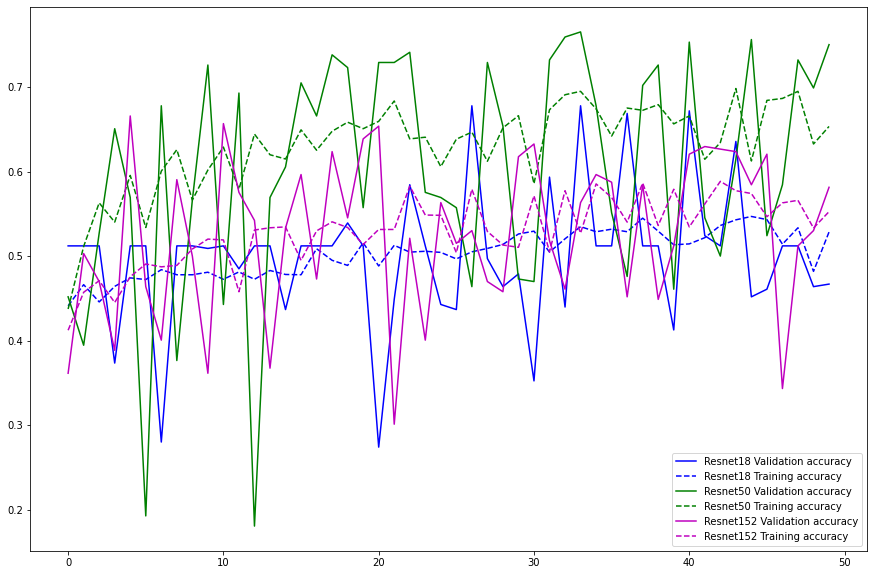

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Plotting traning and validation performance

b_train_acc = []
for val in balanced_tr_hist:
  b_train_acc.append(val.cpu().data.numpy())

b_val_acc = []
for val in balanced_val_hist:
  b_val_acc.append(val.cpu().data.numpy())

b_train_acc2 = []
for val in balanced_tr_hist2:
  b_train_acc2.append(val.cpu().data.numpy())

b_val_acc2 = []
for val in balanced_val_hist2:
  b_val_acc2.append(val.cpu().data.numpy())

b_train_acc3 = []
for val in balanced_tr_hist3:
  b_train_acc3.append(val.cpu().data.numpy())

b_val_acc3 = []
for val in balanced_val_hist3:
  b_val_acc3.append(val.cpu().data.numpy())

# im_train_acc = []
# for val in imbalanced_tr_hist:
#   im_train_acc.append(val.cpu().data.numpy())

# im_val_acc = []
# for val in imbalanced_val_hist:
#   im_val_acc.append(val.cpu().data.numpy())
plt.figure(figsize=(15,10))
plt.plot(b_val_acc, 'b-', label='Resnet18 Validation accuracy')
plt.plot(b_train_acc,'b--', label='Resnet18 Training accuracy')
plt.plot(b_val_acc2, 'g-', label='Resnet50 Validation accuracy')
plt.plot(b_train_acc2,'g--', label='Resnet50 Training accuracy')
plt.plot(b_val_acc3, 'm-', label='Resnet152 Validation accuracy')
plt.plot(b_train_acc3,'m--', label='Resnet152 Training accuracy')
plt.legend()
plt.savefig('64_100epochs_3models.png')
plt.show()
files.download('64_100epochs_3models.png')

In [19]:
# path_to_save = '/content/drive/MyDrive/trained_models'
# torch.save(model_ft_balanced.state_dict(), 'model_64_100epochs_resnet18')
# # torch.save(model_ft_balanced2.state_dict(), 'model_64_100epochs_resnet50')
# # torch.save(model_ft_balanced3.state_dict(), 'model_64_100epochs_resnet152')
# files.download('model_64_100epochs_resnet18')
# files.download('model_64_100epochs_resnet50')
# files.download('model_64_100epochs_resnet152')

In [24]:
test_path_data = 'drive/MyDrive/balanced_csic_data_64/testing'
testing_dataset = torchvision.datasets.ImageFolder(test_path_data, transform=transform)
batch_size = 32
testing_dataloader =torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print(testing_dataset.class_to_idx)


{'Cyperus': 0, 'Negative': 1, 'Portulaca': 2, 'Solanum': 3}


In [21]:
# send model to GPU
if torch.cuda.is_available():
    model_ft_balanced3.cuda()

In [22]:
def getTestingMatrics(dataloader, model):
  # send model to GPU
  if torch.cuda.is_available():
    model.cuda()

  # with tqdm(testing_dataloader) as tepoch:
  lbs = []
  preds = []
  #   # Iterate over data.
  for inputs, labels in dataloader:
    test_inputs = inputs.to(device)
    #test_labels = labels.to(device)
    outputs = model(test_inputs)
    _, pred = torch.max(outputs, 1)
    lbs+=(list(labels.numpy()))
    preds+= list(pred.cpu().data.numpy())
  print('Overall testing accuracy:',accuracy_score(lbs, preds))
  print(classification_report(lbs, preds, target_names=class_dict.keys()))

In [25]:
getTestingMatrics(testing_dataloader, model_ft_balanced)
getTestingMatrics(testing_dataloader, model_ft_balanced2)
getTestingMatrics(testing_dataloader, model_ft_balanced3)

Overall testing accuracy: 0.6270588235294118
              precision    recall  f1-score   support

     Cyperus       0.56      0.55      0.56       302
    Negative       0.66      0.86      0.75       425
   Portulaca       0.00      0.00      0.00        85
     Solanum       0.00      0.00      0.00        38

    accuracy                           0.63       850
   macro avg       0.31      0.35      0.33       850
weighted avg       0.53      0.63      0.57       850



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall testing accuracy: 0.6964705882352941
              precision    recall  f1-score   support

     Cyperus       0.56      0.91      0.70       302
    Negative       0.89      0.71      0.79       425
   Portulaca       0.71      0.18      0.28        85
     Solanum       0.00      0.00      0.00        38

    accuracy                           0.70       850
   macro avg       0.54      0.45      0.44       850
weighted avg       0.72      0.70      0.67       850



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall testing accuracy: 0.5388235294117647
              precision    recall  f1-score   support

     Cyperus       0.50      0.31      0.39       302
    Negative       0.55      0.85      0.67       425
   Portulaca       0.00      0.00      0.00        85
     Solanum       0.00      0.00      0.00        38

    accuracy                           0.54       850
   macro avg       0.26      0.29      0.26       850
weighted avg       0.45      0.54      0.47       850



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
